In [1]:
from __future__ import print_function, division

In [2]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
from time import time

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [3]:
import targeting
import casjobs

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import table
from astropy.table import Table
from astropy.io import fits

from astropy.utils.console import ProgressBar
from astropy.utils import data

from collections import Counter

In [4]:
%matplotlib inline
from matplotlib import style, pyplot as plt

plt.style.use('seaborn-deep')
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14

In [5]:
from IPython import display

In [6]:
# from the DECALS low-SB_brick selection and data download notebook
bricknames = ['1181m012', '2208m005']

For more in-depth on the context for these, see ``DECALS low-SB_catalog completeness.ipynb``

# Load the catalogs 

In [7]:
catalog_fns = ['decals_dr3/catalogs/tractor-{}.fits'.format(bnm) for bnm in bricknames]
decals_catalogs = [Table.read(fn) for fn in catalog_fns]

In [8]:
sdss_fns = ['decals_dr3/catalogs/sdss_comparison_{}.csv'.format(bnm) for bnm in bricknames]
sdss_catalogs = [Table.read(fn) for fn in sdss_fns]

In [9]:
bricks = Table.read('decals_dr3/survey-bricks.fits.gz')
bricksdr3 = Table.read('decals_dr3/survey-bricks-dr3.fits.gz')

## Populate additional DECALS info

In [10]:
A0p5 = 2.5*np.log10(np.pi*(0.5)**2)
A0p75 = 2.5*np.log10(np.pi*(0.75)**2)
A1 = 2.5*np.log10(np.pi*(1.)**2)

for dcat in decals_catalogs:
    dcat['g'] = np.array(22.5 - 2.5*np.log10(dcat['decam_flux'][:, 1]))*u.mag
    dcat['r'] = np.array(22.5 - 2.5*np.log10(dcat['decam_flux'][:, 2]))*u.mag
    dcat['z'] = np.array(22.5 - 2.5*np.log10(dcat['decam_flux'][:, 4]))*u.mag
    
    dcat['sb_r_0.5'] = np.array(22.5 - 2.5*np.log10(dcat['decam_apflux'][:, 2, 0]) + A0p5)*u.mag * u.arcsec**-2
    dcat['sb_r_0.75'] = np.array(22.5 - 2.5*np.log10(dcat['decam_apflux'][:, 2, 1]) + A0p75)*u.mag * u.arcsec**-2
    dcat['sb_r_1'] = np.array(22.5 - 2.5*np.log10(dcat['decam_apflux'][:, 2, 2]) + A1)*u.mag * u.arcsec**-2
    dcat['sb_r_2'] = np.array(22.5 - 2.5*np.log10(dcat['decam_apflux'][:, 2, 4]) + A1)*u.mag * u.arcsec**-2

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/saga/lib

# Cut out areas of overlap from the bricks, and then combine them

In [11]:
boundaries = [((-1.375, -1.2), (118, 118.145)),
              ((-0.625, -0.375), (220.75, 221))]

In [12]:
dcut = []
scut = []

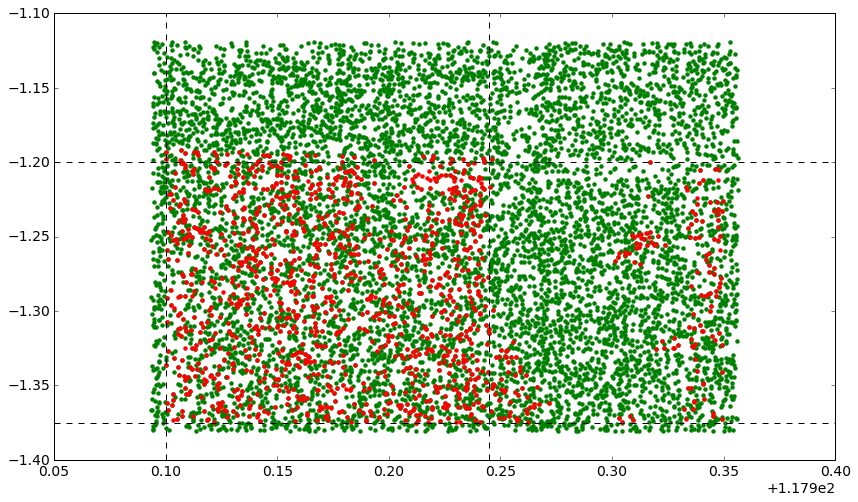

In [13]:
dcat = decals_catalogs[0]
scat = sdss_catalogs[0]
bnds = boundaries[0]

plt.scatter(dcat['ra'], dcat['dec'], lw=0, c='g')
plt.scatter(scat['RA'], scat['DEC'], lw=0, c='r')

plt.axhline(bnds[0][0], c='k', ls='--')
plt.axhline(bnds[0][1], c='k', ls='--')
plt.axvline(bnds[1][0], c='k', ls='--')
plt.axvline(bnds[1][1], c='k', ls='--')

dmsk = ((bnds[1][0]<dcat['ra']) & (dcat['ra']<bnds[1][1]) &
        (bnds[0][0]<dcat['dec']) & (dcat['dec']<bnds[0][1]))
dcut.append(dcat[dmsk])


smsk = ((bnds[1][0]<scat['RA']) & (scat['RA']<bnds[1][1]) &
        (bnds[0][0]<scat['DEC']) & (scat['DEC']<bnds[0][1]))
scut.append(scat[smsk])

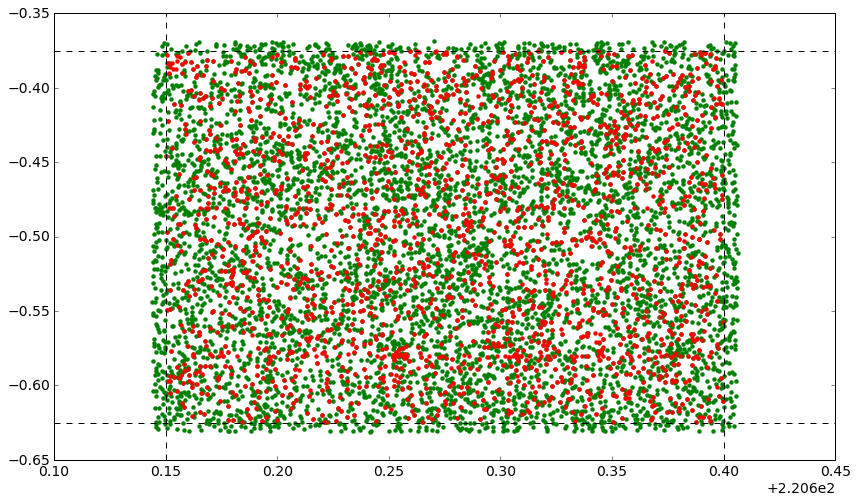

In [14]:
dcat = decals_catalogs[1]
scat = sdss_catalogs[1]
bnds = boundaries[1]

plt.scatter(dcat['ra'], dcat['dec'], lw=0, c='g')
plt.scatter(scat['RA'], scat['DEC'], lw=0, c='r')

plt.axhline(bnds[0][0], c='k', ls='--')
plt.axhline(bnds[0][1], c='k', ls='--')
plt.axvline(bnds[1][0], c='k', ls='--')
plt.axvline(bnds[1][1], c='k', ls='--')

dmsk = ((bnds[1][0]<dcat['ra']) & (dcat['ra']<bnds[1][1]) &
        (bnds[0][0]<dcat['dec']) & (dcat['dec']<bnds[0][1]))
dcut.append(dcat[dmsk])


smsk = ((bnds[1][0]<scat['RA']) & (scat['RA']<bnds[1][1]) &
        (bnds[0][0]<scat['DEC']) & (scat['DEC']<bnds[0][1]))
scut.append(scat[smsk])

In [15]:
dcutall = table.vstack(dcut)
scutall = table.vstack(scut)

# Combined catalog 

In [16]:
dsc = SkyCoord(dcutall['ra'], dcutall['dec'], unit=u.deg)
ssc = SkyCoord(scutall['RA'], scutall['DEC'], unit=u.deg)

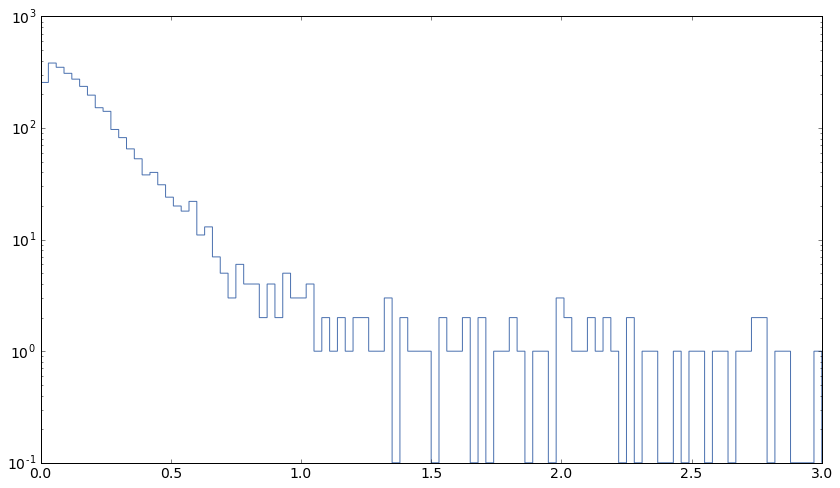

In [17]:
idx, d2d, _ = ssc.match_to_catalog_sky(dsc)
plt.hist(d2d.arcsec, bins=100, range=(0, 3),histtype='step', log=True)
None

In [18]:
dmatch = dcutall[idx[d2d<1.5*u.arcsec]]
smatch = scutall[d2d<1.5*u.arcsec]

In [19]:
didxs = np.arange(len(dcutall))
dnomatch = dcutall[didxs[~np.in1d(didxs, idx[d2d<1.5*u.arcsec])]]

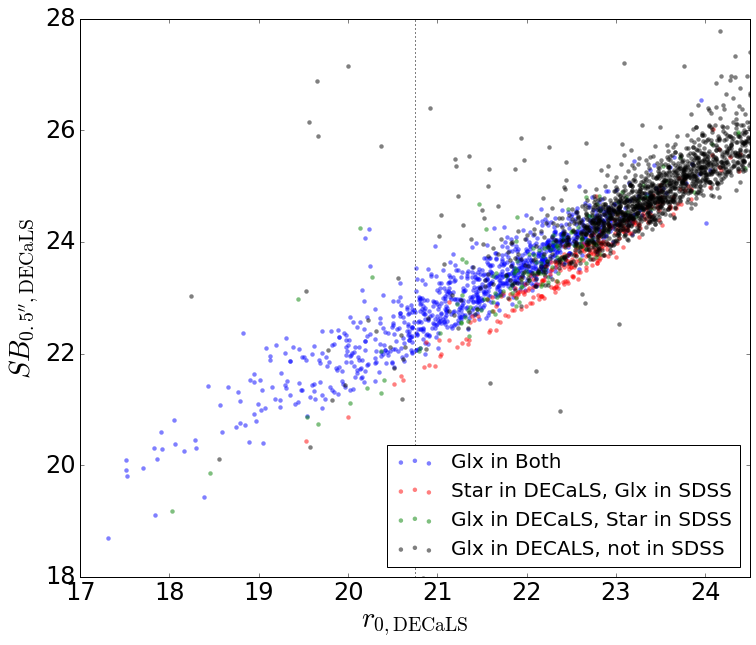

In [20]:
plt.figure(figsize=(12, 10))

xnm = 'r'
ynm = 'sb_r_0.5'

dmextinction = -2.5*np.log10(dmatch['decam_mw_transmission'][:, 2])
x = dmatch[xnm] - dmextinction
y = dmatch[ynm] - dmextinction
dstar = dmatch['type']=='PSF '
sstar = smatch['PHOT_SG']=='STAR'
plt.scatter(x[~dstar&~sstar], y[~dstar&~sstar], c='b', lw=0, alpha=.5, label='Glx in Both')
plt.scatter(x[dstar&~sstar], y[dstar&~sstar], c='r', lw=0, alpha=.5, label='Star in DECaLS, Glx in SDSS')
plt.scatter(x[~dstar&sstar], y[~dstar&sstar], c='g', lw=0, alpha=.5, label='Glx in DECaLS, Star in SDSS')

dnstar = dnomatch['type']=='PSF '
dnoext = -2.5*np.log10(dnomatch['decam_mw_transmission'][:, 2])
plt.scatter((dnomatch[xnm] - dnoext)[~dnstar], (dnomatch[ynm] - dnoext)[~dnstar], 
            c='k', lw=0, alpha=.5, label='Glx in DECALS, not in SDSS')

#plt.hlines(24.5, 17, 21, colors='k', linestyles='--')
plt.axvline(20.75, color='k', ls=':')

plt.xlim(17, 24.5)
plt.ylim(18, 28)

plt.xlabel(r'$r_{0, {\rm DECaLS}}$', fontsize=28)
plt.ylabel(r'$SB_{0.5^{\prime \prime}, {\rm DECaLS}}$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.legend(loc='lower right', fontsize=20)
plt.savefig(os.environ['HOME'] + '/Desktop/fig_decals.pdf')

In [21]:
#high SB

to_check = (dcutall['r']<21)&(dcutall['sb_r_0.5']>24.5) & (dcutall['type']!='PSF ')

de_cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra={0.ra.deg}&dec={0.dec.deg}&layer=decals-dr3&pixscale=0.1&bands=grz'
sd_cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra={0.ra.deg}&dec={0.dec.deg}&layer=sdssco&pixscale=0.1&bands=gri'

print('put this into http://skyserver.sdss.org/dr13/en/tools/chart/listinfo.aspx')
print('name ra dec')

tabrows = []
for row in dcutall[to_check]:
    dviewurl = 'http://legacysurvey.org/viewer?ra={}&dec={}'.format(row['ra'], row['dec'])
    sviewurl = 'http://skyserver.sdss.org/dr12/en/tools/chart/navi.aspx?ra={}&dec={}'.format(row['ra'], row['dec'])
    sc = SkyCoord(row['ra'], row['dec'], unit=u.deg)
    objstr = '{}_{}<br>RA={:.4f}<br>Dec={:.4f}<br>r={:.2f}<br>sb={:.2f}'.format(row['brickid'], row['objid'], row['ra'], row['dec'], row['r'], row['sb_r_0.5'])
    deimg = '<a href="{}"><img src="{}"></a>'.format(dviewurl, de_cutout_url.format(sc))
    sdimg = '<a href="{}"><img src="{}"></a>'.format(sviewurl, sd_cutout_url.format(sc))
    tabrows.append('<tr><td>{}</td><td>{}</td><td>{}</td></tr>'.format(objstr, deimg, sdimg))
    print(row['brickname']+'_'+str(row['objid']), row['ra'], row['dec'])
display.HTML("""
<table>

<tr>
<th>obj</th>
<th>DECALS</th>
<th>SDSS</th>
</tr>

{}
</table>
""".format('\n'.join(tabrows)))

put this into http://skyserver.sdss.org/dr13/en/tools/chart/listinfo.aspx
name ra dec
1181m012_678 118.112199737 -1.36244765285
1181m012_993 118.073844294 -1.35064712055
1181m012_2942 118.093188198 -1.29399519212
1181m012_2945 118.087942554 -1.2876046284
2208m005_785 220.792331062 -0.597459136591


/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


obj,DECALS,SDSS
323640_678RA=118.1122Dec=-1.3624r=20.08sb=27.24,,
323640_993RA=118.0738Dec=-1.3506r=19.64sb=26.22,,
323640_2942RA=118.0932Dec=-1.2940r=19.75sb=25.98,,
323640_2945RA=118.0879Dec=-1.2876r=19.74sb=26.97,,
328371_785RA=220.7923Dec=-0.5975r=20.45sb=25.81,,


All seem to be artifacts in DECaLS - scattered light, cosmic rays, etc

In [22]:
#DE gals, not in SDSS

to_check = ((18<dnomatch['r']) & (dnomatch['r']<21) &
            (18<dnomatch['sb_r_0.5']) & (dnomatch['sb_r_0.5']<24.5) & 
            (dnomatch['type']!='PSF '))

de_cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra={0.ra.deg}&dec={0.dec.deg}&layer=decals-dr3&pixscale=0.1&bands=grz'
sd_cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra={0.ra.deg}&dec={0.dec.deg}&layer=sdssco&pixscale=0.1&bands=gri'


print('put this into http://skyserver.sdss.org/dr13/en/tools/chart/listinfo.aspx')
print('name ra dec')

tabrows = []
for row in dnomatch[to_check]:
    dviewurl = 'http://legacysurvey.org/viewer?ra={}&dec={}'.format(row['ra'], row['dec'])
    sviewurl = 'http://skyserver.sdss.org/dr12/en/tools/chart/navi.aspx?ra={}&dec={}'.format(row['ra'], row['dec'])
    sc = SkyCoord(row['ra'], row['dec'], unit=u.deg)
    objstr = '{}_{}<br>RA={:.4f}<br>Dec={:.4f}<br>r={:.2f}<br>sb={:.2f}'.format(row['brickid'], row['objid'], row['ra'], row['dec'], row['r'], row['sb_r_0.5'])
    deimg = '<a href="{}"><img src="{}"></a>'.format(dviewurl, de_cutout_url.format(sc))
    sdimg = '<a href="{}"><img src="{}"></a>'.format(sviewurl, sd_cutout_url.format(sc))
    tabrows.append('<tr><td>{}</td><td>{}</td><td>{}</td></tr>'.format(objstr, deimg, sdimg))
    print(row['brickname']+'_'+str(row['objid']), row['ra'], row['dec'])
display.HTML("""
<table>

<tr>
<th>obj</th>
<th>DECALS</th>
<th>SDSS</th>
</tr>

{}
</table>
""".format('\n'.join(tabrows)))

put this into http://skyserver.sdss.org/dr13/en/tools/chart/listinfo.aspx
name ra dec
1181m012_961 118.121513445 -1.35257640112
1181m012_1384 118.038073493 -1.34092907625
1181m012_1656 118.090730955 -1.33314864522
1181m012_1800 118.117388763 -1.32869772927
1181m012_2014 118.083627175 -1.32579902208
1181m012_2700 118.112946373 -1.29868529355
1181m012_2876 118.031814095 -1.29029361373
1181m012_2878 118.030590431 -1.29002895308
1181m012_2880 118.028672101 -1.28997846323
1181m012_2912 118.003665054 -1.29901194917
1181m012_2935 118.087672265 -1.29341850195
1181m012_3798 118.088913439 -1.26723945505
1181m012_4682 118.087427046 -1.23734510488
1181m012_4685 118.088564737 -1.24490918031
1181m012_5813 118.090766692 -1.20919653906
2208m005_968 220.855751224 -0.592980315504
2208m005_2626 220.816086592 -0.533070890865
2208m005_4659 220.897160891 -0.458573580142
2208m005_6437 220.812481307 -0.398810751892
2208m005_6656 220.750771946 -0.386014017194


/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


obj,DECALS,SDSS
323640_961RA=118.1215Dec=-1.3526r=20.60sb=21.82,,
323640_1384RA=118.0381Dec=-1.3409r=20.64sb=20.31,,
323640_1656RA=118.0907Dec=-1.3331r=19.85sb=22.16,,
323640_1800RA=118.1174Dec=-1.3287r=19.66sb=20.41,,
323640_2014RA=118.0836Dec=-1.3258r=20.05sb=21.52,,
323640_2700RA=118.1129Dec=-1.2987r=20.40sb=22.49,,
323640_2876RA=118.0318Dec=-1.2903r=20.68sb=22.43,,
323640_2878RA=118.0306Dec=-1.2900r=20.69sb=21.28,,
323640_2880RA=118.0287Dec=-1.2900r=20.70sb=21.98,,
323640_2912RA=118.0037Dec=-1.2990r=20.64sb=23.44,,


These are almost entirely either deblender ambiguities (i.e. by eye may or may not be two sources) or areas where SDSS had a scattered-light/background problem.  A few debatebly real objects, but not preferentially low-SB or anything.

# Try with other aperture sizes

This also has a few more points for stars just to see the differences.  That's why we still include 0.5 even though it's above, too

## 0.5" 

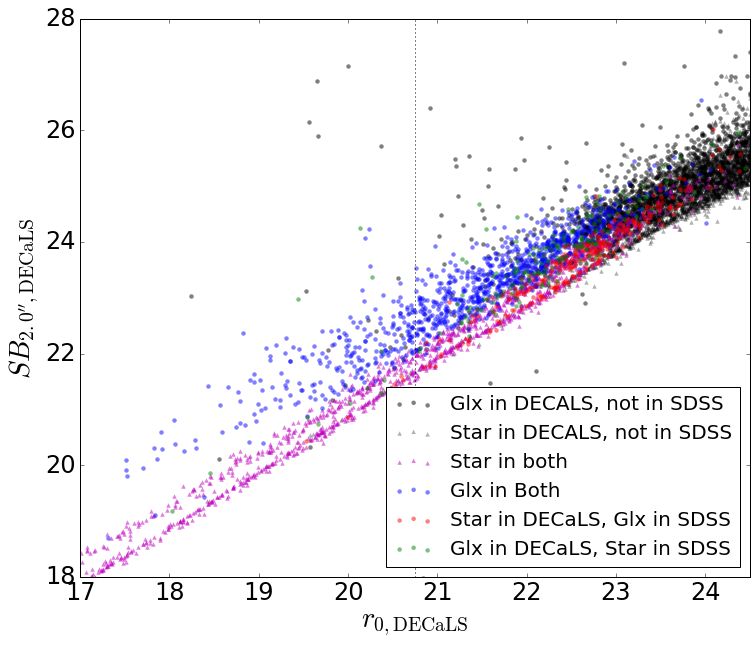

In [23]:
plt.figure(figsize=(12, 10))

xnm = 'r'
ynm = 'sb_r_0.5'

dmextinction = -2.5*np.log10(dmatch['decam_mw_transmission'][:, 2])
x = dmatch[xnm] - dmextinction
y = dmatch[ynm] - dmextinction
dstar = dmatch['type']=='PSF '
sstar = smatch['PHOT_SG']=='STAR'


dnstar = dnomatch['type']=='PSF '
dnoext = -2.5*np.log10(dnomatch['decam_mw_transmission'][:, 2])
plt.scatter((dnomatch[xnm] - dnoext)[~dnstar], (dnomatch[ynm] - dnoext)[~dnstar], 
            c='k', lw=0, alpha=.5, label='Glx in DECALS, not in SDSS')
plt.scatter((dnomatch[xnm] - dnoext)[dnstar], (dnomatch[ynm] - dnoext)[dnstar], 
            c='k', lw=0, alpha=.3, label='Star in DECALS, not in SDSS', marker='^')

plt.scatter(x[dstar&sstar], y[dstar&sstar], c='m', lw=0, alpha=.5, label='Star in both', marker='^')

plt.scatter(x[~dstar&~sstar], y[~dstar&~sstar], c='b', lw=0, alpha=.5, label='Glx in Both')
plt.scatter(x[dstar&~sstar], y[dstar&~sstar], c='r', lw=0, alpha=.5, label='Star in DECaLS, Glx in SDSS')
plt.scatter(x[~dstar&sstar], y[~dstar&sstar], c='g', lw=0, alpha=.5, label='Glx in DECaLS, Star in SDSS')




#plt.hlines(24.5, 17, 21, colors='k', linestyles='--')
plt.axvline(20.75, color='k', ls=':')

plt.xlim(17, 24.5)
plt.ylim(18, 28)

plt.xlabel(r'$r_{0, {\rm DECaLS}}$', fontsize=28)
plt.ylabel(r'$SB_{2.0^{\prime \prime}, {\rm DECaLS}}$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.legend(loc='lower right', fontsize=20)

## 0.75" 

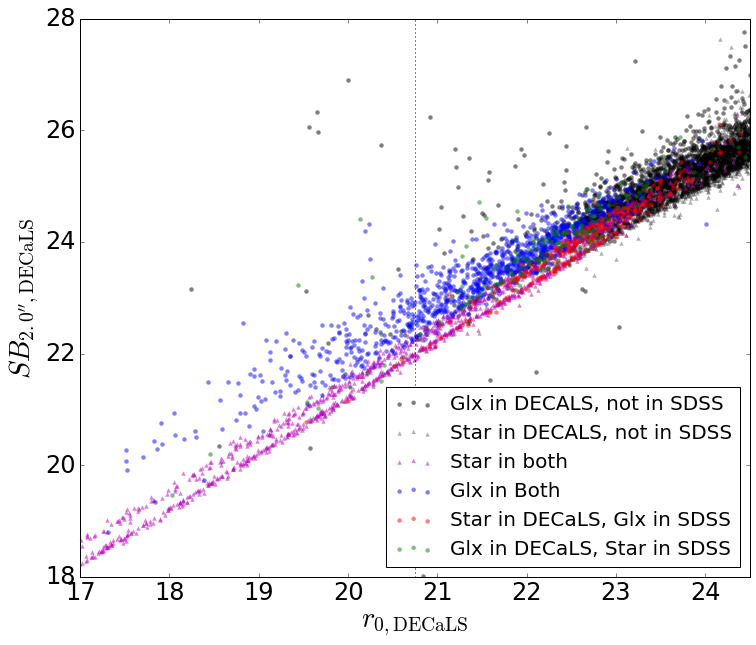

In [24]:
plt.figure(figsize=(12, 10))

xnm = 'r'
ynm = 'sb_r_0.75'

dmextinction = -2.5*np.log10(dmatch['decam_mw_transmission'][:, 2])
x = dmatch[xnm] - dmextinction
y = dmatch[ynm] - dmextinction
dstar = dmatch['type']=='PSF '
sstar = smatch['PHOT_SG']=='STAR'


dnstar = dnomatch['type']=='PSF '
dnoext = -2.5*np.log10(dnomatch['decam_mw_transmission'][:, 2])
plt.scatter((dnomatch[xnm] - dnoext)[~dnstar], (dnomatch[ynm] - dnoext)[~dnstar], 
            c='k', lw=0, alpha=.5, label='Glx in DECALS, not in SDSS')
plt.scatter((dnomatch[xnm] - dnoext)[dnstar], (dnomatch[ynm] - dnoext)[dnstar], 
            c='k', lw=0, alpha=.3, label='Star in DECALS, not in SDSS', marker='^')

plt.scatter(x[dstar&sstar], y[dstar&sstar], c='m', lw=0, alpha=.5, label='Star in both', marker='^')

plt.scatter(x[~dstar&~sstar], y[~dstar&~sstar], c='b', lw=0, alpha=.5, label='Glx in Both')
plt.scatter(x[dstar&~sstar], y[dstar&~sstar], c='r', lw=0, alpha=.5, label='Star in DECaLS, Glx in SDSS')
plt.scatter(x[~dstar&sstar], y[~dstar&sstar], c='g', lw=0, alpha=.5, label='Glx in DECaLS, Star in SDSS')




#plt.hlines(24.5, 17, 21, colors='k', linestyles='--')
plt.axvline(20.75, color='k', ls=':')

plt.xlim(17, 24.5)
plt.ylim(18, 28)

plt.xlabel(r'$r_{0, {\rm DECaLS}}$', fontsize=28)
plt.ylabel(r'$SB_{2.0^{\prime \prime}, {\rm DECaLS}}$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.legend(loc='lower right', fontsize=20)

## 1.0" 

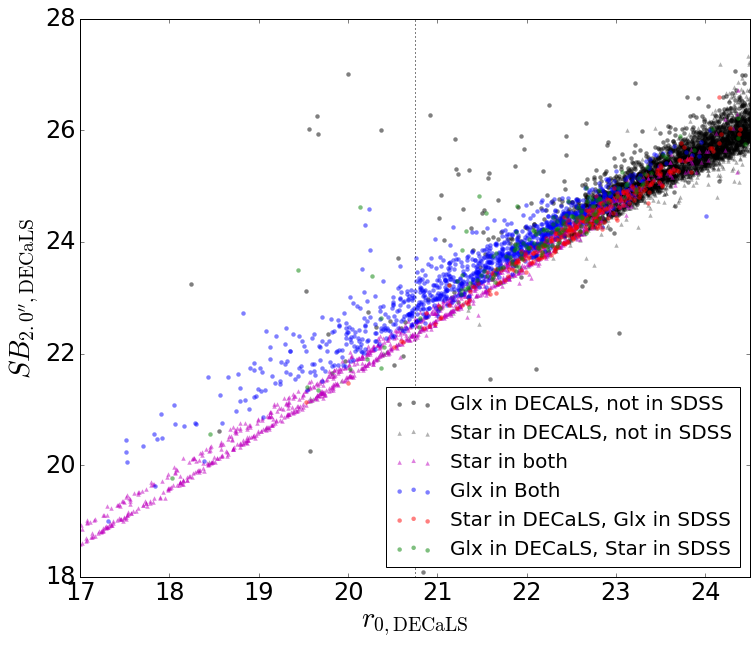

In [25]:
plt.figure(figsize=(12, 10))

xnm = 'r'
ynm = 'sb_r_1'

dmextinction = -2.5*np.log10(dmatch['decam_mw_transmission'][:, 2])
x = dmatch[xnm] - dmextinction
y = dmatch[ynm] - dmextinction
dstar = dmatch['type']=='PSF '
sstar = smatch['PHOT_SG']=='STAR'


dnstar = dnomatch['type']=='PSF '
dnoext = -2.5*np.log10(dnomatch['decam_mw_transmission'][:, 2])
plt.scatter((dnomatch[xnm] - dnoext)[~dnstar], (dnomatch[ynm] - dnoext)[~dnstar], 
            c='k', lw=0, alpha=.5, label='Glx in DECALS, not in SDSS')
plt.scatter((dnomatch[xnm] - dnoext)[dnstar], (dnomatch[ynm] - dnoext)[dnstar], 
            c='k', lw=0, alpha=.3, label='Star in DECALS, not in SDSS', marker='^')

plt.scatter(x[dstar&sstar], y[dstar&sstar], c='m', lw=0, alpha=.5, label='Star in both', marker='^')

plt.scatter(x[~dstar&~sstar], y[~dstar&~sstar], c='b', lw=0, alpha=.5, label='Glx in Both')
plt.scatter(x[dstar&~sstar], y[dstar&~sstar], c='r', lw=0, alpha=.5, label='Star in DECaLS, Glx in SDSS')
plt.scatter(x[~dstar&sstar], y[~dstar&sstar], c='g', lw=0, alpha=.5, label='Glx in DECaLS, Star in SDSS')




#plt.hlines(24.5, 17, 21, colors='k', linestyles='--')
plt.axvline(20.75, color='k', ls=':')

plt.xlim(17, 24.5)
plt.ylim(18, 28)

plt.xlabel(r'$r_{0, {\rm DECaLS}}$', fontsize=28)
plt.ylabel(r'$SB_{2.0^{\prime \prime}, {\rm DECaLS}}$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.legend(loc='lower right', fontsize=20)

## 2.0" 

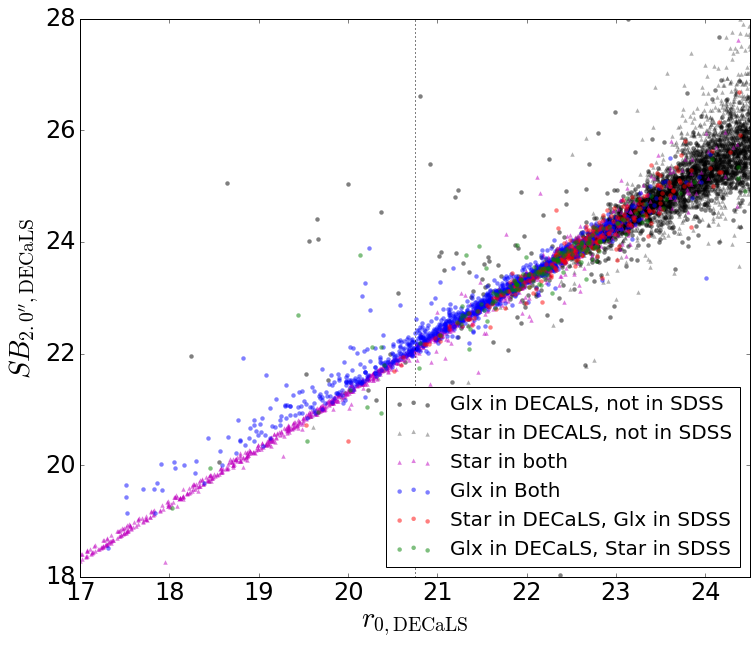

In [26]:
plt.figure(figsize=(12, 10))

xnm = 'r'
ynm = 'sb_r_2'

dmextinction = -2.5*np.log10(dmatch['decam_mw_transmission'][:, 2])
x = dmatch[xnm] - dmextinction
y = dmatch[ynm] - dmextinction
dstar = dmatch['type']=='PSF '
sstar = smatch['PHOT_SG']=='STAR'


dnstar = dnomatch['type']=='PSF '
dnoext = -2.5*np.log10(dnomatch['decam_mw_transmission'][:, 2])
plt.scatter((dnomatch[xnm] - dnoext)[~dnstar], (dnomatch[ynm] - dnoext)[~dnstar], 
            c='k', lw=0, alpha=.5, label='Glx in DECALS, not in SDSS')
plt.scatter((dnomatch[xnm] - dnoext)[dnstar], (dnomatch[ynm] - dnoext)[dnstar], 
            c='k', lw=0, alpha=.3, label='Star in DECALS, not in SDSS', marker='^')

plt.scatter(x[dstar&sstar], y[dstar&sstar], c='m', lw=0, alpha=.5, label='Star in both', marker='^')

plt.scatter(x[~dstar&~sstar], y[~dstar&~sstar], c='b', lw=0, alpha=.5, label='Glx in Both')
plt.scatter(x[dstar&~sstar], y[dstar&~sstar], c='r', lw=0, alpha=.5, label='Star in DECaLS, Glx in SDSS')
plt.scatter(x[~dstar&sstar], y[~dstar&sstar], c='g', lw=0, alpha=.5, label='Glx in DECaLS, Star in SDSS')




#plt.hlines(24.5, 17, 21, colors='k', linestyles='--')
plt.axvline(20.75, color='k', ls=':')

plt.xlim(17, 24.5)
plt.ylim(18, 28)

plt.xlabel(r'$r_{0, {\rm DECaLS}}$', fontsize=28)
plt.ylabel(r'$SB_{2.0^{\prime \prime}, {\rm DECaLS}}$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.legend(loc='lower right', fontsize=20)

# Interpolated exponential SB

We want to try to get a surface birghtness something like SDSS's expmag + 2.5 log10(2 pi exprad^2).  But DECaLS has no expmag.  So lets try interpolating the aperture fluxes to the appropriate radius.

In [27]:
rap_sizes = [0.5,0.75,1.0,1.5,2.0,3.5,5.0,7.0] * u.arcsec 
rap_fluxes = dmatch['decam_apflux'][:, 2, :]

expflux = np.empty_like(rap_fluxes[:, 0])
rap_sizesv = rap_sizes.to(u.arcsec).value
for i in ProgressBar(range(len(rap_fluxes)), ipython_widget=True):
    f = rap_fluxes[i]
    r = dmatch['shapeExp_r'][i]
    expflux[i] = np.interp(r, rap_sizesv, f)
    

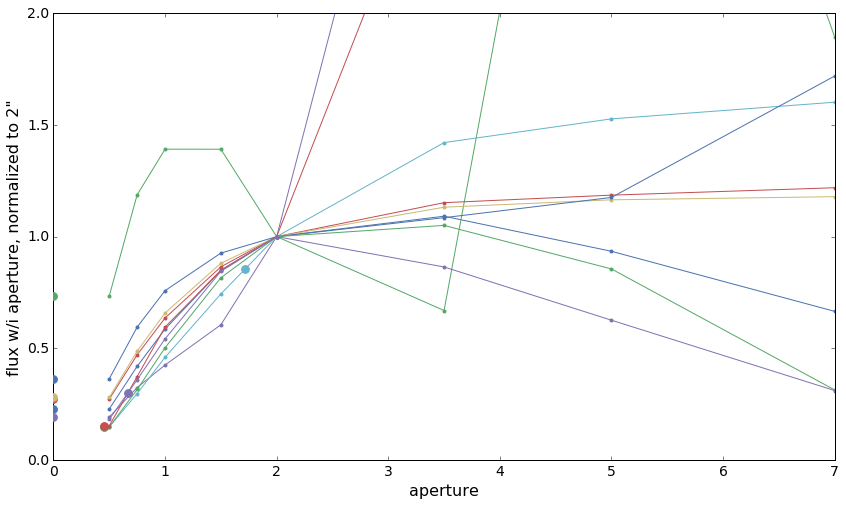

In [28]:
j = 0
for i in np.random.permutation(len(rap_fluxes)):
    fnorm = rap_fluxes[i][4]
    p = plt.plot(rap_sizes, rap_fluxes[i]/fnorm,'-o', ms=4, mew=0)[0]
    plt.scatter([dmatch['shapeExp_r'][i]], [expflux[i]/fnorm], color=p.get_color(), s=60, zorder=5)
    j += 1
    if j>9:
        break

plt.xlim(0, 7)
plt.ylim(0, 2)
plt.xlabel('aperture')
plt.ylabel('flux w/i aperture, normalized to 2"')

What's the deal with all those objects that have an shapeExp_r of 0?

In [29]:
Counter(dmatch[dmatch['shapeExp_r']>0]['type']), Counter(dmatch[dmatch['shapeExp_r']==0]['type'])

(Counter({'COMP': 22, 'EXP ': 636, 'SIMP': 366}),
 Counter({'DEV ': 146, 'PSF ': 1714}))

Oops... looks like stars, and more importantly, DeV-fit galaxies, have no shapeExp_r!

# Galaxy detection depth 

In [30]:
maggaldepth = -2.5*(np.log10(5*dmatch['decam_galdepth']**-0.5)-9)
maggaldepthr = maggaldepth[:, 2]

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


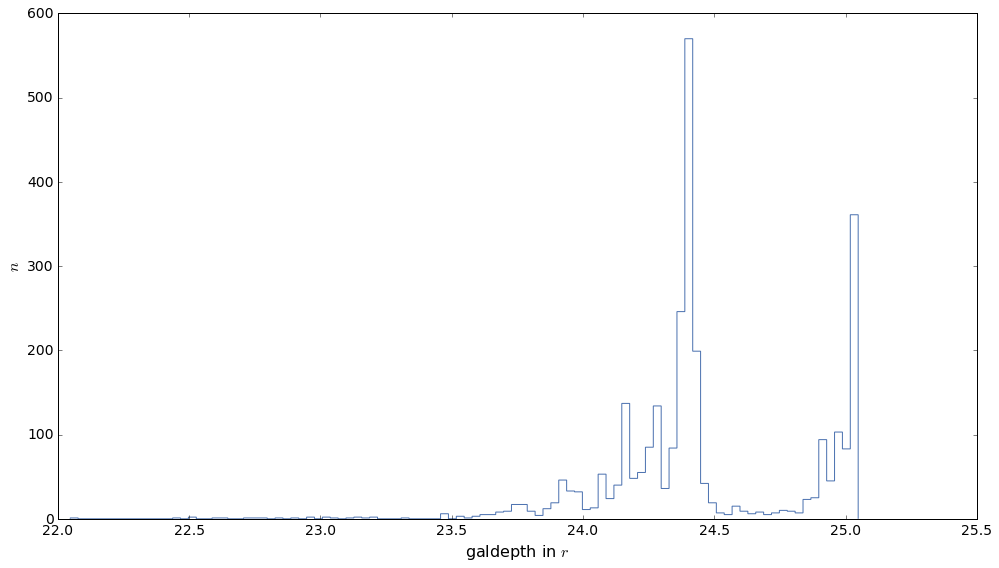

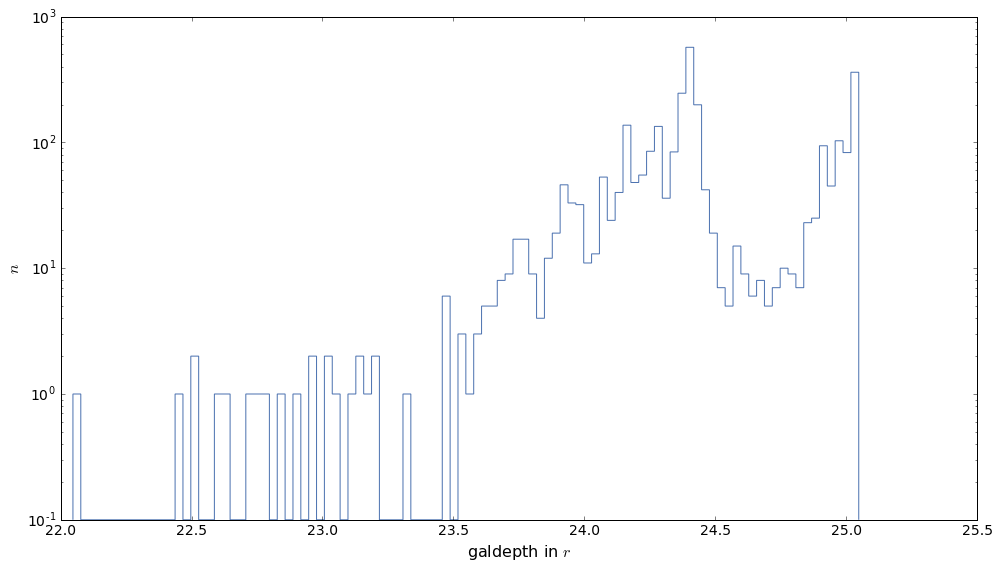

In [31]:
plt.figure()
plt.hist(maggaldepthr[np.isfinite(maggaldepthr)], bins=100, histtype='step', log=False)
plt.xlabel('galdepth in $r$')
plt.ylabel('$n$')
plt.tight_layout()

plt.figure()
plt.hist(maggaldepthr[np.isfinite(maggaldepthr)], bins=100, histtype='step', log=True)
plt.xlabel('galdepth in $r$')
plt.ylabel('$n$')
plt.tight_layout()

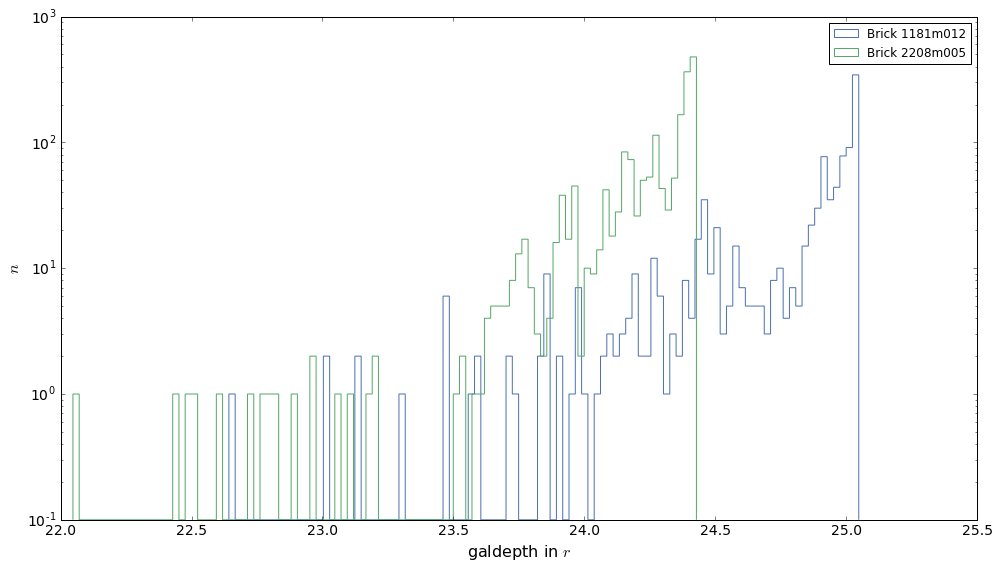

In [32]:
for bnm in np.unique(dmatch['brickname']):
    inbrick = dmatch['brickname'] == bnm
    plt.hist(maggaldepthr[np.isfinite(maggaldepthr)&inbrick], bins=100, histtype='step', log=True, label='Brick '+bnm)
   
plt.xlabel('galdepth in $r$')
plt.ylabel('$n$')
plt.legend(loc=0)
plt.tight_layout()